In [2]:
# Load Dataset

import kagglehub

path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/face-expression-recognition-dataset


In [3]:
import os

os.listdir(path)

['images']

In [4]:
path = os.path.join(path, 'images')
os.listdir(path)

['validation', 'images', 'train']

In [5]:
trainDir = os.path.join(path, 'train')
valDir = os.path.join(path, 'validation')

In [6]:
print(os.listdir(trainDir))
print(os.listdir(valDir))

['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']
['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']


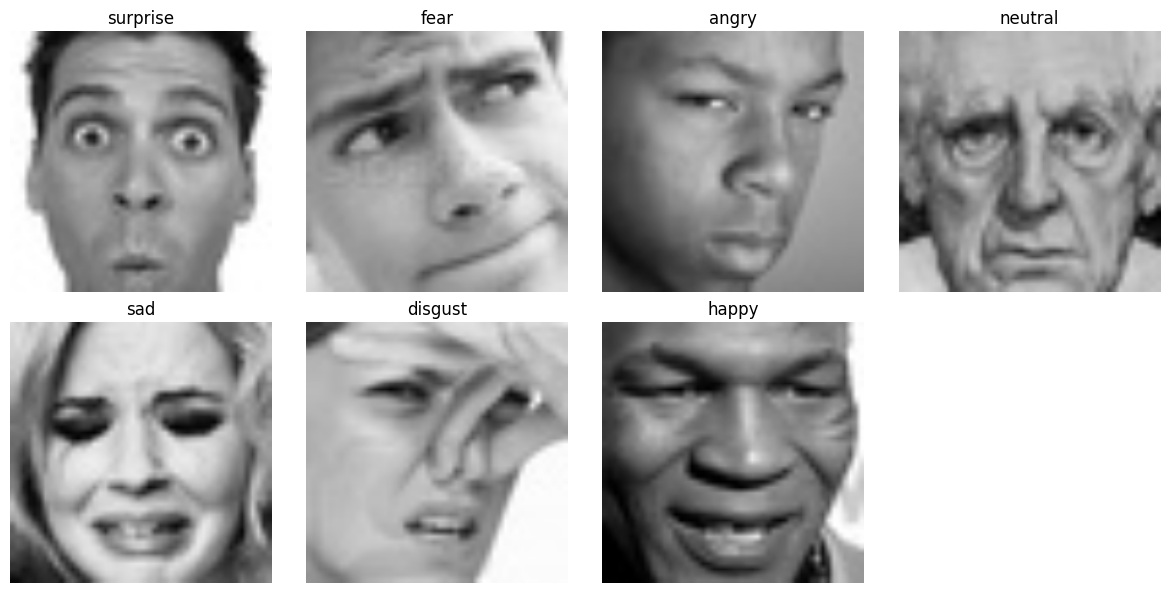

In [7]:
#  Visualize Some Images

import matplotlib.pyplot as plt
import cv2
import random

categories = os.listdir(trainDir)
imgSize = 224

plt.figure(figsize = (12, 6))
for i, category in enumerate(categories):
    folder = os.path.join(trainDir, category)
    imgName = random.choice(os.listdir(folder))
    imgPath = os.path.join(folder, imgName)
    img = cv2.imread(imgPath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (imgSize, imgSize))

    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
# Data Generators with Augmentation
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batchSize = 32
noOfEpochs = 25
numClasses = 7

trainDatagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.15,
    brightness_range=(0.7, 1.3),
    horizontal_flip=True
)

trainGenerator = trainDatagen.flow_from_directory(
    trainDir,
    target_size=(imgSize, imgSize),
    batch_size=batchSize,
    class_mode='categorical',
    color_mode='rgb',
    subset='training'
)

valGenerator = trainDatagen.flow_from_directory(
    valDir,
    target_size=(imgSize, imgSize),
    batch_size=batchSize,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation',
    shuffle=False
)


Found 23060 images belonging to 7 classes.
Found 1411 images belonging to 7 classes.


In [9]:
# Build Model with EfficientNetB0
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(imgSize, imgSize, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(numClasses, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# Compute Class Weights for Imbalance
from sklearn.utils import class_weight
import collections

y_train = trainGenerator.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

counter = collections.Counter(y_train)
print("Class distribution:", counter)

Class distribution: Counter({3: 5732, 4: 3986, 5: 3951, 2: 3283, 0: 3195, 6: 2564, 1: 349})


In [11]:
# Compile and Train Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

import os
os.makedirs('/kaggle/working/models', exist_ok=True)  # Make sure folder exist

checkpoint = ModelCheckpoint('models/best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(
    trainGenerator,
    validation_data=valGenerator,
    epochs=noOfEpochs,
    class_weight=class_weight_dict,
    callbacks=[checkpoint, earlystop, lr_reduce]
)

Epoch 1/25
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.1384 - loss: 1.9492
Epoch 1: val_accuracy improved from -inf to 0.16088, saving model to models/best_model.keras
721/721 ━━━━━━━━━━━━━━━━━━━━ 489s 641ms/step - accuracy: 0.1383 - loss: 1.9492 - val_accuracy: 0.1609 - val_loss: 1.9499 - learning_rate: 0.0010
Epoch 2/25
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.0901 - loss: 1.9510
Epoch 2: val_accuracy did not improve from 0.16088
721/721 ━━━━━━━━━━━━━━━━━━━━ 339s 466ms/step - accuracy: 0.0900 - loss: 1.9510 - val_accuracy: 0.1609 - val_loss: 1.9463 - learning_rate: 0.0010
Epoch 3/25
720/721 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.1364 - loss: 1.9428
Epoch 3: val_accuracy did not improve from 0.16088
721/721 ━━━━━━━━━━━━━━━━━━━━ 330s 454ms/step - accuracy: 0.1364 - loss: 1.9429 - val_accuracy: 0.1609 - val_loss: 1.9471 - learning_rate: 0.0010
Epoch 4/25
720/721 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.0559 - loss: 1.9698
Epoch 4: val_accur

In [19]:
# Fine-Tuning
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

fineTune_epochs = 60
model.fit(
    trainGenerator,
    validation_data=valGenerator,
    epochs=fineTune_epochs,
    class_weight=class_weight_dict,
    callbacks=[checkpoint, earlystop, lr_reduce]
)

Epoch 1/60
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.5367 - loss: 1.1931
Epoch 1: val_accuracy did not improve from 0.55563
721/721 ━━━━━━━━━━━━━━━━━━━━ 444s 528ms/step - accuracy: 0.5367 - loss: 1.1931 - val_accuracy: 0.5471 - val_loss: 1.1905 - learning_rate: 1.0000e-05
Epoch 2/60
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.5318 - loss: 1.1909
Epoch 2: val_accuracy did not improve from 0.55563
721/721 ━━━━━━━━━━━━━━━━━━━━ 338s 464ms/step - accuracy: 0.5318 - loss: 1.1909 - val_accuracy: 0.5478 - val_loss: 1.1711 - learning_rate: 1.0000e-05
Epoch 3/60
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.5410 - loss: 1.1694
Epoch 3: val_accuracy improved from 0.55563 to 0.56414, saving model to models/best_model.keras
721/721 ━━━━━━━━━━━━━━━━━━━━ 339s 466ms/step - accuracy: 0.5410 - loss: 1.1693 - val_accuracy: 0.5641 - val_loss: 1.1511 - learning_rate: 1.0000e-05
Epoch 4/60
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.5511 - loss: 1.1486
Epo

In [13]:
# Save Final Model
model.save('models/final_model.keras')
print("Model saved to /kaggle/working/models/final_model.keras")

Model saved to /kaggle/working/models/final_model.keras


In [14]:
print("Saved model at:", os.path.abspath("models/final_model.keras"))

Saved model at: /kaggle/working/models/final_model.keras


In [15]:
# Classification Report
from sklearn.metrics import classification_report, confusion_matrix

valGenerator.reset()
pred_probs = model.predict(valGenerator)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = valGenerator.classes
class_labels = list(valGenerator.class_indices.keys())

print("\nClassification Report:")
print(classification_report(true_classes, pred_classes, target_names=class_labels))

45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 514ms/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.49      0.36      0.42       192
     disgust       0.22      0.77      0.34        22
        fear       0.41      0.18      0.25       203
       happy       0.84      0.75      0.79       365
     neutral       0.49      0.56      0.52       243
         sad       0.43      0.50      0.46       227
    surprise       0.56      0.82      0.67       159

    accuracy                           0.55      1411
   macro avg       0.49      0.56      0.49      1411
weighted avg       0.56      0.55      0.54      1411



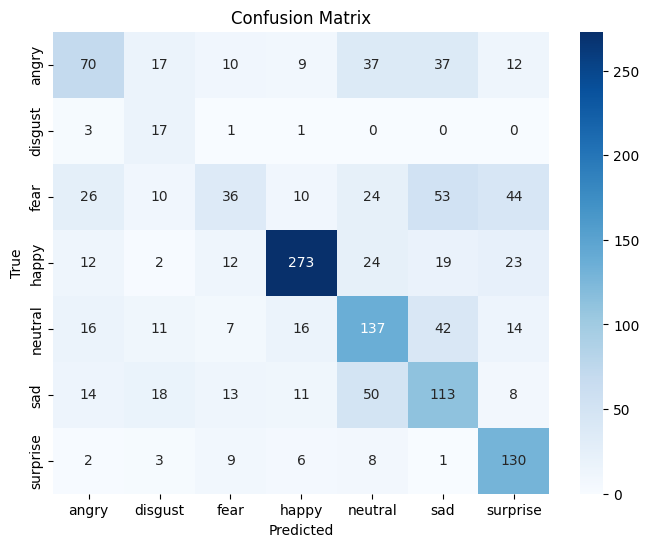

In [16]:
# Confusion Matrix
import seaborn as sns

cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 397ms/step


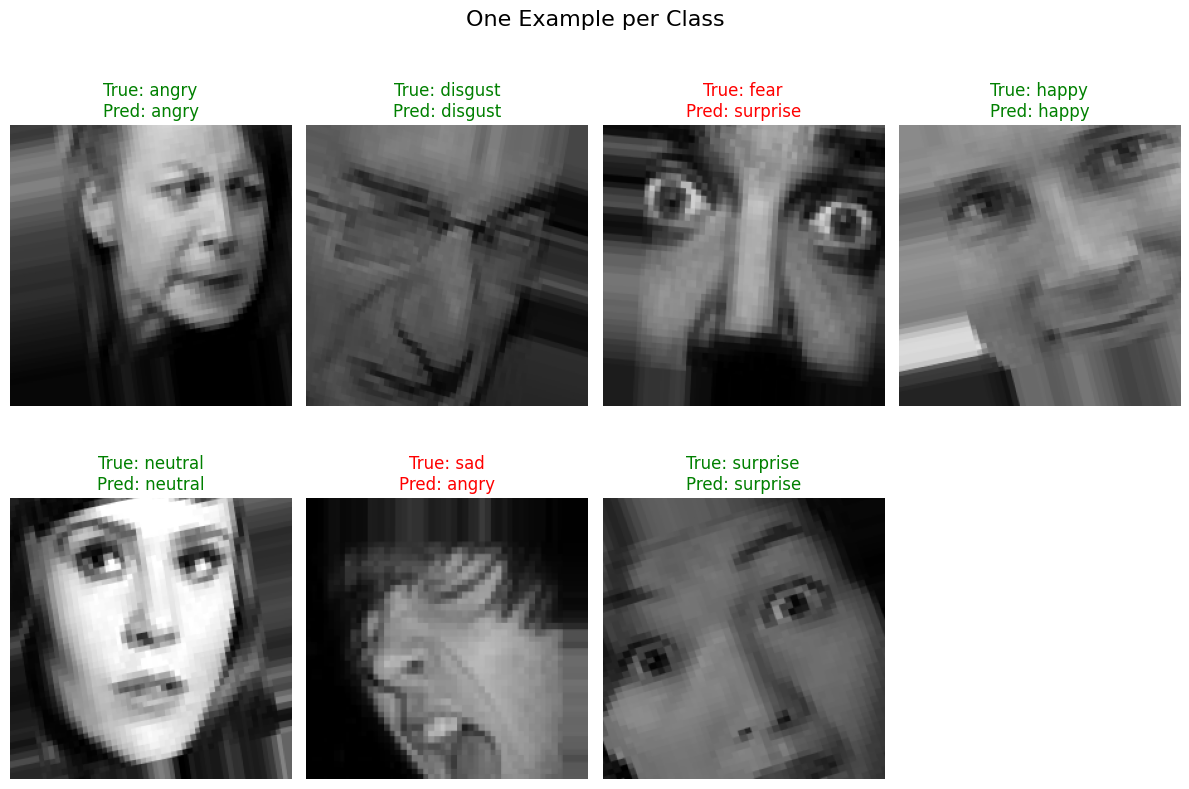

In [21]:
# Reset generator
valGenerator.reset()

# Get all predictions
pred_probs = model.predict(valGenerator)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = valGenerator.classes
class_labels = list(valGenerator.class_indices.keys())

# 🔍 Collect one sample per class
import matplotlib.pyplot as plt
import numpy as np

seen_classes = set()
selected_images = []
selected_true = []
selected_pred = []

for i in range(len(true_classes)):
    true_label = true_classes[i]
    pred_label = pred_classes[i]

    if true_label not in seen_classes:
        # Load the corresponding image manually
        batch_index = i // valGenerator.batch_size
        image_index = i % valGenerator.batch_size

        valGenerator.batch_index = batch_index
        images, _ = next(valGenerator)

        selected_images.append(images[image_index])
        selected_true.append(true_label)
        selected_pred.append(pred_label)
        seen_classes.add(true_label)

    if len(seen_classes) == len(class_labels):
        break

# Plot
plt.figure(figsize=(12, 8))
for i in range(len(class_labels)):
    plt.subplot(2, 4, i+1)
    plt.imshow(selected_images[i])
    true_lbl = class_labels[selected_true[i]]
    pred_lbl = class_labels[selected_pred[i]]
    color = 'green' if selected_true[i] == selected_pred[i] else 'red'
    plt.title(f"True: {true_lbl}\nPred: {pred_lbl}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.suptitle("One Example per Class", fontsize=16, y=1.05)
plt.show()


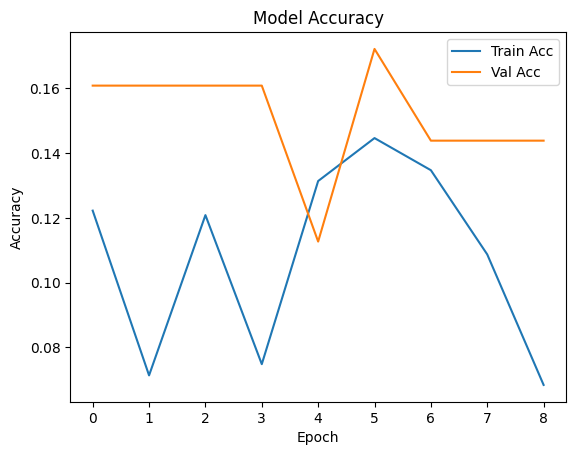

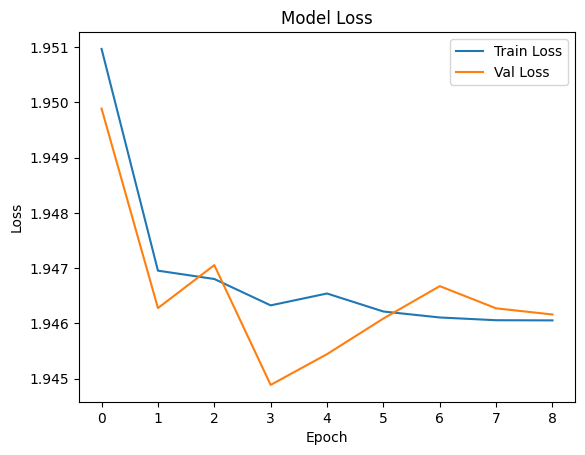

In [18]:
# Accuracy & Loss Graphs
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()